<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch PlayGround

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import ml_collections
import wandb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


Using device: cpu


## Config

In [3]:
cfg = ml_collections.ConfigDict()

# Logger
cfg.wandb_project = "cvpr2021"
cfg.dataset = "mnist_8x8"
cfg.wandb_entity = "ipl_uv"

cfg.batch_size = 128
cfg.num_workers = 8
cfg.seed = 123

# Data
cfg.n_train = 5_000
cfg.n_valid = 1_000
cfg.n_test = 10_000
cfg.noise = 0.05

# Model
cfg.loss_fn = "bpd"
cfg.n_layers = 8
cfg.multiscale = False
cfg.n_reflections = 10
cfg.n_bins = 8
cfg.model = "rnvp"
cfg.actnorm = True

# Training
cfg.num_epochs = 100
cfg.lr_scheduler = "cosine_annealing"
cfg.weight_decay = 1e-4
cfg.gamma = 0.99
cfg.learning_rate = 1e-3
cfg.n_total_steps = cfg.num_epochs * cfg.n_train

# Testing
cfg.importance_samples = 8
cfg.temperature = 1.0

In [4]:
seed_everything(cfg.seed)

Global seed set to 123


123

## Logging

In [5]:
wandb_logger = WandbLogger(project=cfg.wandb_project, entity=cfg.wandb_entity)
wandb_logger.experiment.config.update(cfg)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: emanjohnson91 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [135]:
from sklearn.datasets import load_digits
from torch.utils.data import Dataset, DataLoader
from einops import rearrange, repeat

class DigitsDataset(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode: str='train', image: bool=True, transforms: bool=None):
        digits = load_digits()
        

        
        # change shape
        if image:
            digits = digits.images
            digits = repeat(digits, "B H W -> B C H W", C=1,)
        else:
            digits = digits.data
            
        if mode == 'train':
            self.data = digits[:1000]
        elif mode == 'val':
            self.data = digits[1000:1350]
        else:
            self.data = digits[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transforms:
            sample = self.transforms(sample)
        return sample

# class DiscretizeDigits:
#     def __init__(self):
        
#         def transform()

In [128]:
num_x = 4
num_y = 4
digits = load_digits()

data = digits.images#[:1000]

# fig, ax = plt.subplots(num_x, num_y)
# for i, ax in enumerate(ax.flatten()):
#     plottable_image = np.reshape(data[i], (8, 8))
#     ax.imshow(plottable_image, cmap='gray')
#     ax.axis('off')

In [129]:
discretize(digits.images).min(), discretize(digits.images).max()

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [130]:
digits.images

array([[[ 0.,  0.,  5., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ..., 15.,  5.,  0.],
        [ 0.,  3., 15., ..., 11.,  8.,  0.],
        ...,
        [ 0.,  4., 11., ..., 12.,  7.,  0.],
        [ 0.,  2., 14., ..., 12.,  0.,  0.],
        [ 0.,  0.,  6., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  5.,  0.,  0.],
        [ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  3., ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.]],

       [[ 0.,  0.,  0., ..., 12.,  0.,  0.],
        [ 0.,  0.,  3., ..., 14.,  0.,  0.],
        [ 0.,  0.,  8., ..., 16.,  0.,  0.],
        ...,
        [ 0.,  9., 16., ...,  0.,  0.,  0.],
        [ 0.,  3., 13., ..., 11.,  5.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.]],

       ...,

       [[ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0., 13., ...,  2.,  1.,  0.],
        [ 0.,  0., 16., ..., 16.,  5.,  0.

In [8]:
def plot_digits(data, num_x, num_y):
    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = data[i]
        
        if data.ndim == 2:
            plottable_image = np.reshape(plottable_image, (8, 8))
        
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')
    plt.show()
    return None

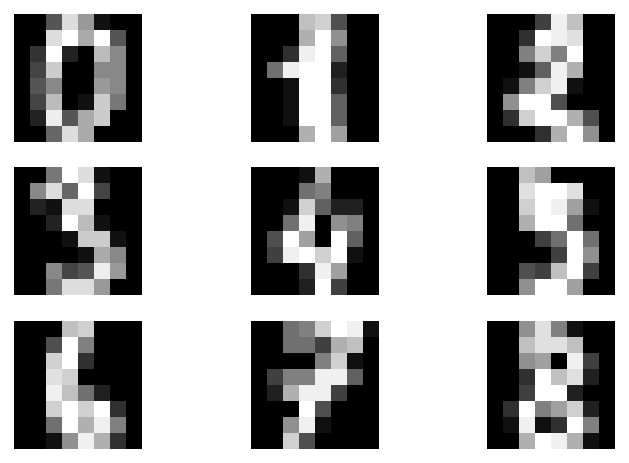

In [9]:
plot_digits(data, 3,3)

#### DataLoader

In [133]:
# from pl_bolts.datamodules import SklearnDataModule, SklearnDataset
from torchvision.transforms import Compose, ToTensor


def discretize(sample):
    return (sample/16.0 * 255).to(torch.int32)


# transformations
transforms = Compose([
    torch.Tensor,
    discretize
])

train_ds = DigitsDataset(mode="train", image=True, transforms=transforms)
valid_ds = DigitsDataset(mode="valid", image=True, transforms=transforms)
test_ds = DigitsDataset(mode="test", image=True, transforms=transforms)

train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=0)

In [136]:
len(train_ds)

1000

## Model

## Normalizing Flow Models

In [82]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.dequantization import UniformDequantization
from src.models.layers.convolutions import Conv1x1, Conv1x1Householder, ConvExponential

#### Coupling Network

In [83]:
# subset net
def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 64,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(64,  c_out, 3, padding=1))

### RealNVP Model

In [84]:
def append_realnvp_coupling_block_image(
    inn,
    conditioner: Callable,
    n_reflections=10,
    actnorm: bool=False,
    mask: str="checkerboard"
    
):
    # =======================
    # checkboard downsampling
    # =======================
    if mask == "checkerboard":
        inn.append(
            Fm.IRevNetDownsampling, 
        )
    elif mask == "wavelet":
        inn.append(
            Fm.HaarDownsampling,
    )
    else:
        raise ValueError(f"Unrecognized masking method: {mask}")
    
    # =================
    # RealNVP Coupling
    # =================
    inn.append(
        Fm.RNVPCouplingBlock, 
        subnet_constructor=conditioner, 
    )
    # Upsampling
    if mask == "checkerboard":
        inn.append(
            Fm.IRevNetUpsampling, 
        )
    elif mask == "wavelet":
        inn.append(
            Fm.HaarUpsampling,
    )
    else:
        raise ValueError(f"Unrecognized masking method: {mask}")
    
    # =========
    # act norm
    # =========
    if actnorm:
        inn.append(
            Fm.ActNorm, 
        )
    # ===============
    # 1x1 Convolution with householder parameterization
    # ===============
    if n_reflections is not None:
        inn.append(
            Conv1x1Householder, 
            n_reflections=n_reflections, 
        )
    else:
        inn.append(
            Conv1x1, 
            n_reflections 
        )
    return inn
    
        

#### Architecture (Simple)

In [85]:
# a simple chain of operations is collected by ReversibleSequential

batch = 100
n_channels = 1
height = 8
width = 8

n_scales = 1
n_subflows = 8

inn = Ff.SequenceINN(n_channels, height, width)

X_init = train_ds[:16]

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

print("Input:")
print(X_init.shape, np.prod(inn(X_init)[0].shape))


for isubflow in range(cfg.n_layers):
    
    # append RealNVP Coupling Block
    inn = append_realnvp_coupling_block_image(
        inn,
        conditioner=subnet_conv, 
        actnorm=True, 
        n_reflections=2,
        mask="checkerboard"
    )

# # SCALE I
# print(f"Scale: 1")
# print("DownSample")
# inn.append(
#     Fm.IRevNetDownsampling, 
# )

# print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape))
    
# for isubflow in range(n_subflows):
    
#     # append RealNVP Coupling Block
#     inn = append_realnvp_coupling_block_image(
#         inn,
#         conditioner=subnet_conv, 
#         actnorm=True, 
#         n_reflections=2,
#         mask="checkerboard"
#     )
    
    
    
inn.append(Fm.Flatten)
print("Final:")
print(inn(X_init)[0].shape)

Input:
torch.Size([16, 1, 8, 8]) 1024
Final:
torch.Size([16, 64])


### Architecture (Multiscale)

In [108]:
# a simple chain of operations is collected by ReversibleSequential

batch = 100
n_channels = 1
height = 8
width = 8

n_scales = 1
n_subflows = 8

inn = Ff.SequenceINN(n_channels, height, width)

X_init = train_ds[:16]

# uniform dequantization (for integers)
inn.append(
    UniformDequantization,
    num_bits=8
)

print("Input:")
print(X_init.shape, np.prod(inn(X_init)[0].shape))


for isubflow in range(2):
    
    # append RealNVP Coupling Block
    inn = append_realnvp_coupling_block_image(
        inn,
        conditioner=subnet_conv, 
        actnorm=True, 
        n_reflections=2,
        mask="checkerboard"
    )

# SCALE I
print(f"Scale: 1")
print("DownSample")
inn.append(
    Fm.IRevNetDownsampling, 
)

print(inn(X_init)[0].shape, np.prod(inn(X_init)[0].shape))
    
for isubflow in range(4):
    
    # append RealNVP Coupling Block
    inn = append_realnvp_coupling_block_image(
        inn,
        conditioner=subnet_conv, 
        actnorm=True, 
        n_reflections=2,
        mask="checkerboard"
    )
    
    
    
inn.append(Fm.Flatten)
print("Final:")
print(inn(X_init)[0].shape)

Input:
torch.Size([16, 1, 8, 8]) 1024
Scale: 1
DownSample
torch.Size([16, 4, 4, 4]) 1024
Final:
torch.Size([16, 64])


## Image Flow Model

In [109]:
from src.lit_image import ImageFlow

In [110]:
flow_img_mnist = ImageFlow(inn, cfg=cfg, prior=None)

### Forward

In [111]:
z, log_jac_det = flow_img_mnist.model.forward(X_init)
print(z.shape)

torch.Size([16, 64])


#### Inverse

In [112]:
x_ori, log_jac_det = flow_img_mnist.model.forward(z, rev=True)
print(x_ori.shape)

torch.Size([16, 1, 8, 8])


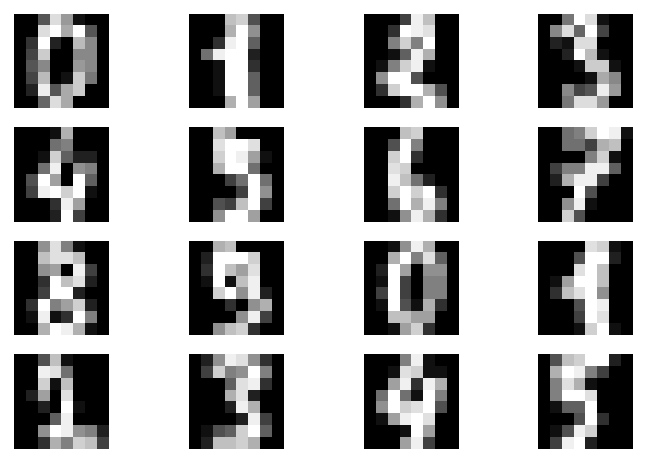

In [113]:
plot_digits(x_ori.detach().numpy().squeeze(), 4, 4)

#### Samples

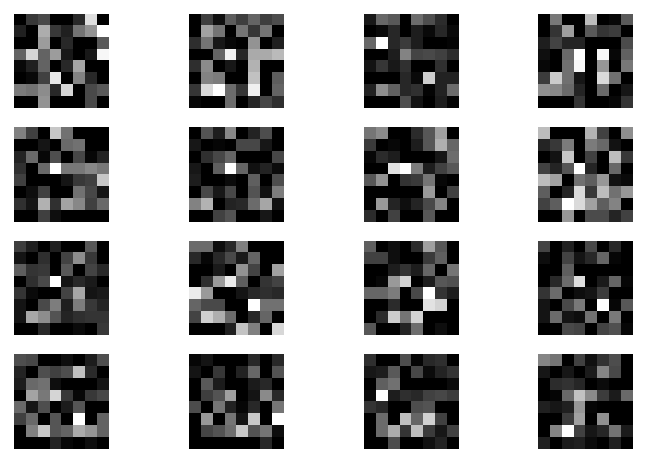

In [114]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 16
# z = torch.randn(n_samples, N_DIM)
samples = flow_img_mnist.sample((100, 64))

plot_digits(samples.detach().numpy().squeeze(), 4, 4)

## Training

In [115]:
%%wandb

trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=1.0, 
    gradient_clip_algorithm='norm',
    logger=wandb_logger
    
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [116]:
trainer.fit(flow_img_mnist, train_dataloader=train_dl, val_dataloaders=valid_dl)

Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 168 K 
--------------------------------------
167 K     Trainable params
592       Non-trainable params
168 K     Total params
0.673     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 123
/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 56 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

#### Latent Space

In [117]:
x = torch.Tensor(X_init)
z, log_jac_det = flow_img_mnist.model(x)

# plot_digits(z.detach().numpy(), 4, 4)

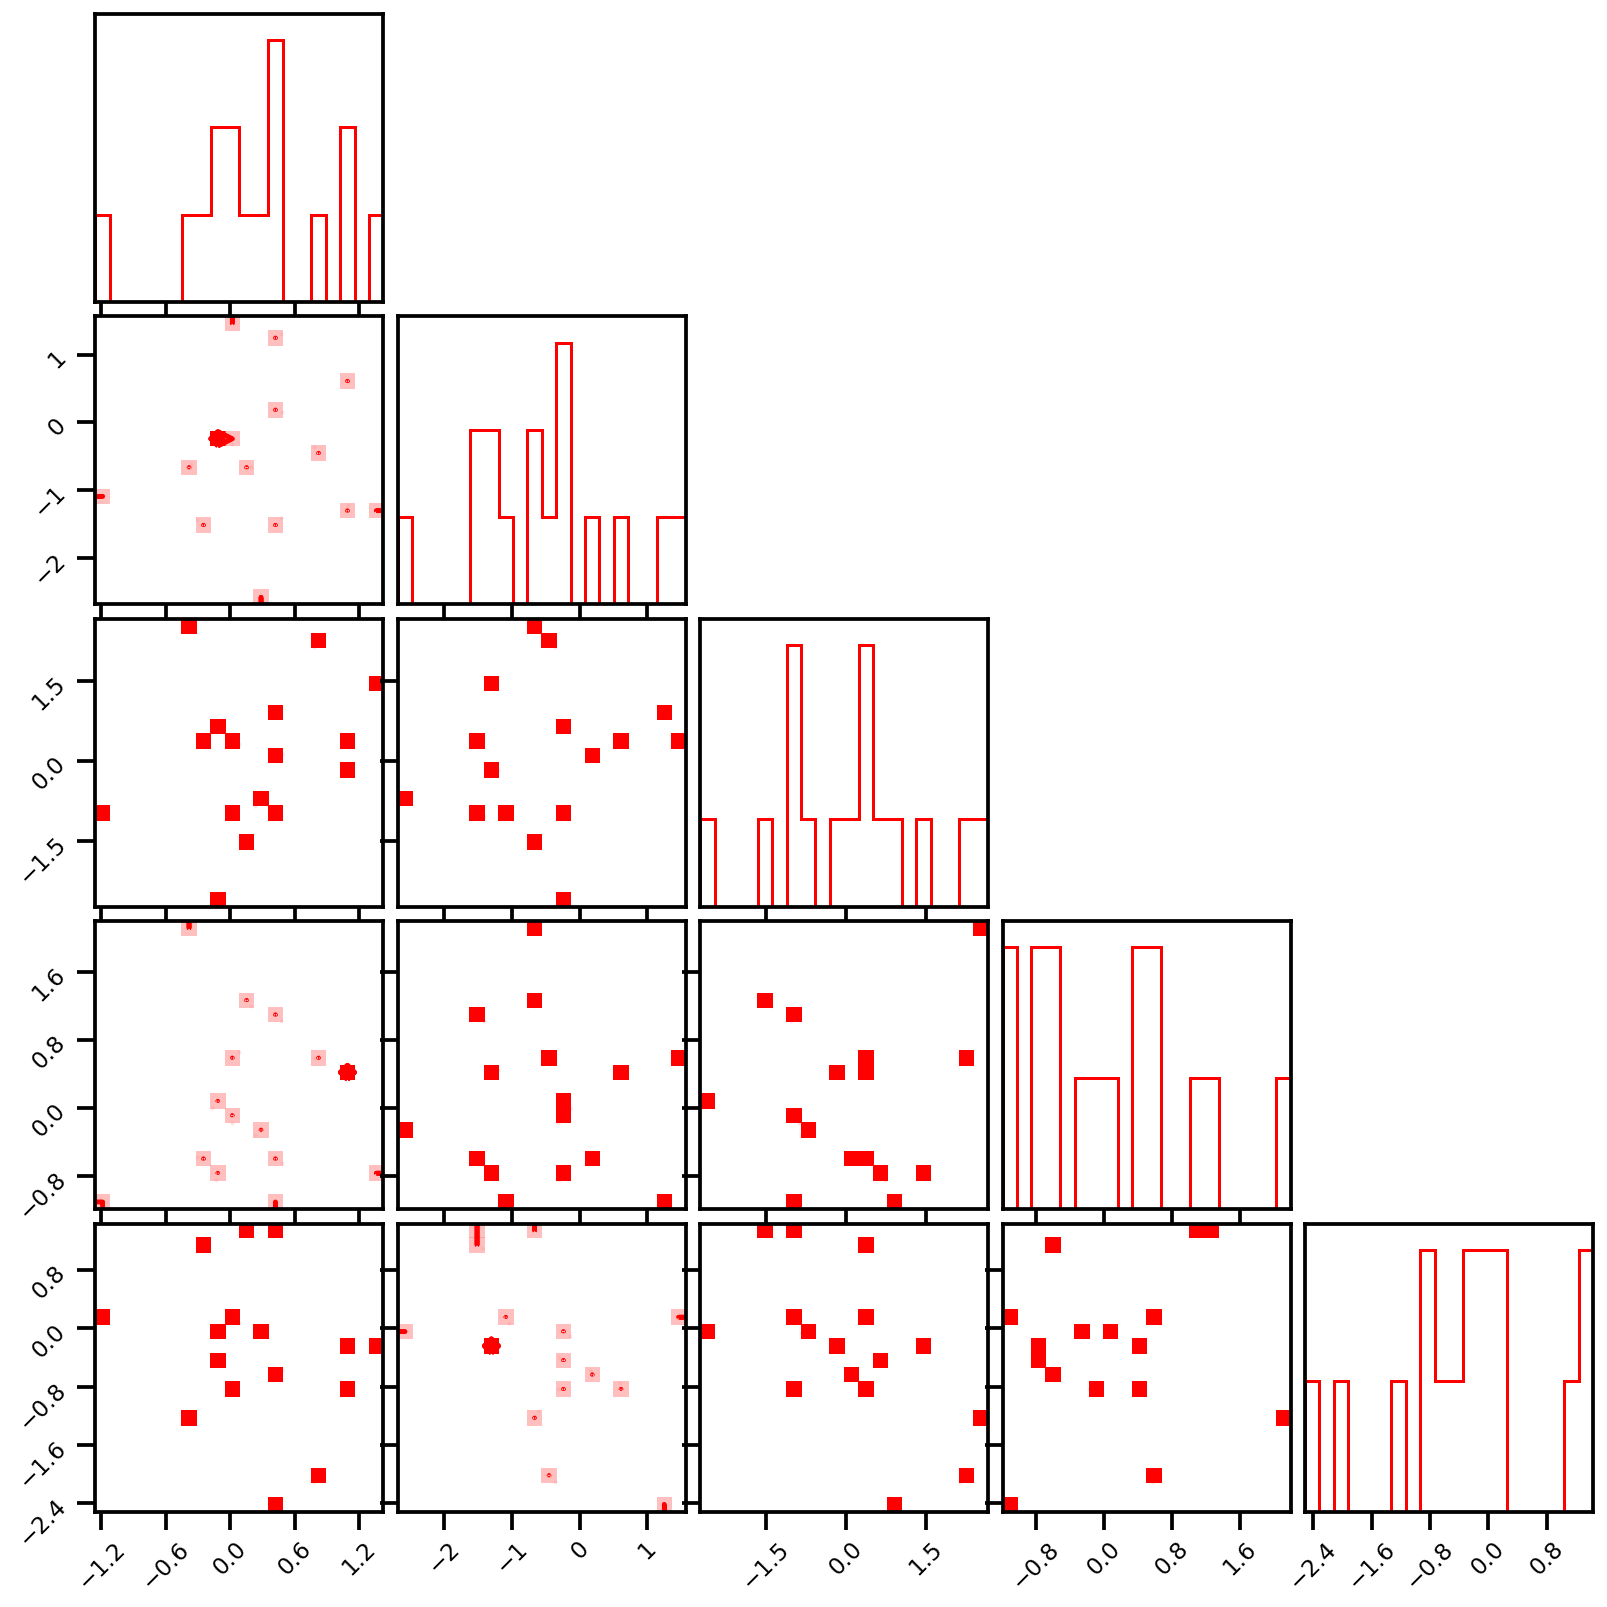

In [118]:
fig = corner.corner(z.detach().numpy()[:, :5], hist_factor=2, color="red")

#### Inverse Transform

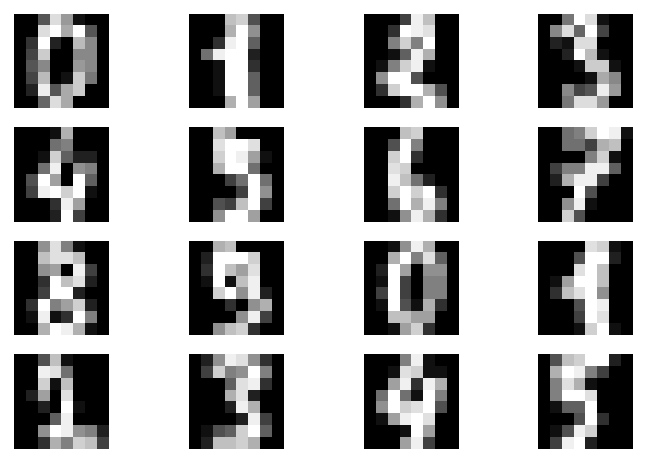

In [119]:
x_ori, _ = flow_img_mnist.model.forward(z, rev=True)

plot_digits(x_ori.detach().numpy().squeeze(), 4, 4)

In [120]:
x_ori.shape

torch.Size([16, 1, 8, 8])

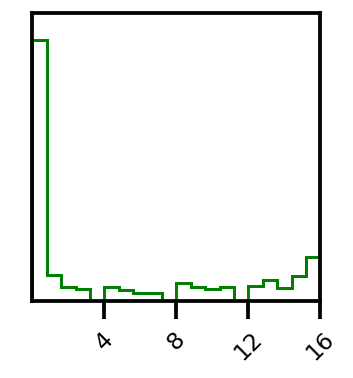

In [105]:
fig = corner.corner(x_ori.detach().numpy()[:, :5, ...].flatten(), hist_factor=2, color="green")

#### Sampling

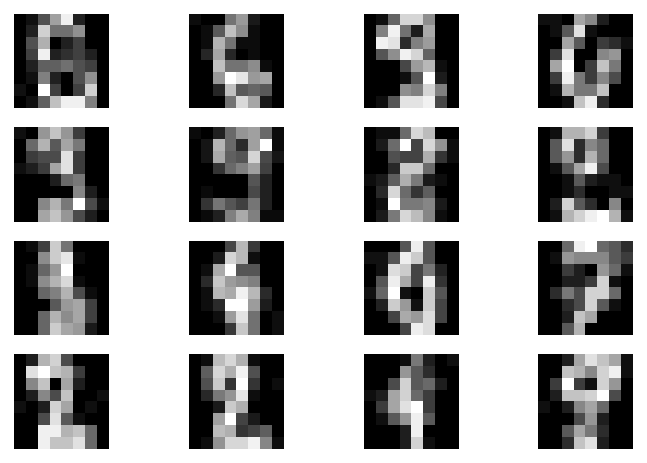

In [121]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 16
# z = torch.randn(n_samples, N_DIM)
samples = flow_img_mnist.sample((100, 64))

plot_digits(samples.detach().numpy().squeeze(), 4, 4)

In [ ]:
fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")